# Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import torch
import random
import numpy as np

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Import

In [ ]:
import sys
import time
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchsummary import summary
from scipy.special import expit as sigmoid
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, SGD, AdamW, Adamax, RMSprop
from sklearn.metrics import classification_report, accuracy_score

sys.path.append('/content/drive/MyDrive/Teeth/mednet')
from model import generate_model

# Parameters

In [ ]:
epoch = 100
batch_size = 16
input_shape = (100, 1, 55, 55)
learning_rate = 1e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset

In [ ]:
def prepare_data():
    with np.load("/content/drive/MyDrive/Teeth/Final/train.npz") as data:
        x_train = data['x']
        y_train = data['y']

    with np.load("/content/drive/MyDrive/Teeth/Final/Validation.npz") as data:
        x_val = data['x']
        y_val = data['y']

    with np.load("/content/drive/MyDrive/Teeth/Final/Test.npz") as data:
        x_test = data['x'].astype(np.float32)
        y_test = data['y']

    x_train = x_train.transpose(0, 4, 1, 2, 3)
    x_val = x_val.transpose(0, 4, 1, 2, 3)
    x_test = x_test.transpose(0, 4, 1, 2, 3)

    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
    val_dataset = TensorDataset(torch.tensor(x_val, dtype=torch.float32),
                                torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))
    test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                torch.tensor(y_test, dtype=torch.float32).unsqueeze(1))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = prepare_data()

# Model

In [ ]:
class Options:
    def __init__(self):
        self.model = 'resnet'
        self.model_depth = 50
        self.resnet_shortcut = 'B'
        self.no_cuda = False
        self.gpu_id = [0]
        self.n_seg_classes = 1
        self.input_W = 55
        self.input_H = 55
        self.input_D = 100
        self.phase = 'train'
        self.pretrain_path = f'/content/drive/MyDrive/Teeth/Checkpoints/resnet_{self.model_depth}_23dataset.pth'
        self.new_layer_names = []


class CustomMedicalNet(nn.Module):
    def __init__(self, opt: Options, output_dim=1):
        super(CustomMedicalNet, self).__init__()

        encoder, _ = generate_model(opt)

        if hasattr(encoder.module, 'fc'):
            encoder.module.fc = nn.Identity()
        if hasattr(encoder.module, 'conv_seg'):
            encoder.module.conv_seg = nn.Identity()

        for param in encoder.parameters():
            param.requires_grad = False

        self.encoder = encoder

        self.global_pool = nn.AdaptiveAvgPool3d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, output_dim))

    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.criterion = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        bce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


opt = Options()
model = CustomMedicalNet(opt, output_dim=1)
model = model.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
summary(model, input_size=(1, 100, 55, 55))

/content/drive/MyDrive/Teeth/mednet/models/resnet.py:173: FutureWarning: `nn.init.kaiming_normal` is now deprecated in favor of `nn.init.kaiming_normal_`.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


loading pretrained model /content/drive/MyDrive/Teeth/Checkpoints/resnet_50_23dataset.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 64, 50, 28, 28]          21,952
       BatchNorm3d-2       [-1, 64, 50, 28, 28]             128
              ReLU-3       [-1, 64, 50, 28, 28]               0
         MaxPool3d-4       [-1, 64, 25, 14, 14]               0
            Conv3d-5       [-1, 64, 25, 14, 14]           4,096
       BatchNorm3d-6       [-1, 64, 25, 14, 14]             128
              ReLU-7       [-1, 64, 25, 14, 14]               0
            Conv3d-8       [-1, 64, 25, 14, 14]         110,592
       BatchNorm3d-9       [-1, 64, 25, 14, 14]             128
             ReLU-10       [-1, 64, 25, 14, 14]               0
           Conv3d-11      [-1, 256, 25, 14, 14]          16,384
      BatchNorm3d-12      [-1, 256, 25, 14, 14]             512
           Co

# Train

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, min_lr=1e-7)

best_val_loss = float('inf')
patience = 20
patience_counter = 0
save_path = "/content/drive/MyDrive/Teeth/Checkpoints/best_model_2.pth"

for ep in range(epoch):
    start_time = time.time()
    model.train()
    train_loss = 0
    all_train_preds = []
    all_train_labels = []

    print(f"\nEpoch {ep+1}/{epoch}")

    for xb, yb in tqdm(train_loader, desc="Training", leave=True):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        all_train_preds.extend(preds.detach().cpu().numpy())
        all_train_labels.extend(yb.cpu().numpy())

    train_loss /= len(train_loader)
    train_probs = sigmoid(np.array(all_train_preds))
    train_preds = (train_probs > 0.5).astype(int)
    train_labels = np.array(all_train_labels).astype(int).flatten()
    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(yb.cpu().numpy())

    val_loss   /= len(val_loader)
    val_probs   = sigmoid(np.array(all_val_preds))
    val_preds   = (val_probs > 0.5).astype(int)
    val_labels  = np.array(all_val_labels).astype(int).flatten()
    val_acc     = accuracy_score(val_labels, val_preds)
    scheduler.step(val_loss)

    elapsed_time = time.time() - start_time

    print(f"Time: {elapsed_time:.2f}s | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), save_path)
        print("Saved Best Model")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Evaluation


Test Accuracy: 62.50%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.29      0.42        45
         1.0       0.59      0.92      0.72        51

    accuracy                           0.62        96
   macro avg       0.68      0.61      0.57        96
weighted avg       0.67      0.62      0.58        96



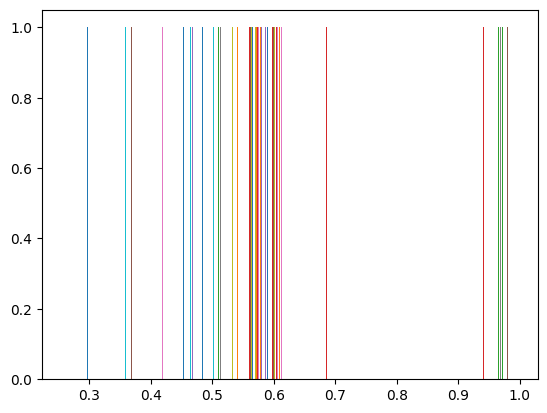

In [ ]:
model.load_state_dict(torch.load(save_path))
model.eval()
all_preds = []
all_labels = []
prediction = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        probabilities = torch.sigmoid(preds)
        prediction.extend(probabilities.cpu().numpy())
        predictions = (probabilities > 0.5).float()
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(yb.numpy())

y_pred = np.round(np.array(all_preds)).astype(int).flatten()
y_true = np.array(all_labels).flatten()
test_acc = accuracy_score(y_true, y_pred)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_true, y_pred))

plt.hist(prediction)
plt.show()